In [2]:
import matplotlib
import Bio.SeqIO
import Bio.Restriction
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import numpy as np

In [235]:
# standard deviation with Bionano data
def signmaS(len):
    singma = (0.2*0.2) + len * 0.1 * (-0.1) + len*len*0.04*0.04
    return(singma)

In [236]:
handle = open("/s/fir/a/nobackup/data/ECOLI_Reference_Genome/ecoli.fa", "rU")
for record in Bio.SeqIO.parse(handle, "fasta"):
    ref_seq = record.seq
frag_sizes = [len(seq) for seq in Bio.Restriction.XhoI.catalyse(ref_seq)]

In [237]:
def subseq(seq, limits):
    x,y = limits
    if x < y : return seq[x:y]
    return seq[x:len(seq)] + seq[0:y]

In [238]:
molecules = []
for i in range(200):
    breaks = []
    num_breaks = 10 #random.randint(20,50)
    for j in range(num_breaks):
        breaks.append(random.randint(0,len(ref_seq) - 1))
    breaks.sort()        
    pairs = [(x,y) for x,y in zip(breaks[:-1], breaks[1:])] + [(breaks[-1], breaks[0])]
    molecules += [[subseq(ref_seq, pair), pair] for pair in pairs]

In [251]:
def sim(mol):
    "Return a simulated set of fragment sizes in bp for a Bio.SeqIO seq"
    error_locations = []
    sites = [biosite - 1 for biosite in Bio.Restriction.XhoI.search(mol)]
    e_f_sites = list(sites);
    
    for i, site in enumerate(sites):
        if (random.randint(1,5) == 5):
            sites.pop(i)
            error_locations.append(i+1)                    
            
    allsites = [0] + sites + [len(mol)]
    e_f_allsites = [0] + e_f_sites + [len(mol)]
    # TODO add random break sites
    sizes = [y - x for x,y in zip(allsites[:-1], allsites[1:])]
    print(sizes)
    print(sum(sizes))
    e_f_sizes = [y - x for x,y in zip(e_f_allsites[:-1], e_f_allsites[1:])]
    sizes = [size/1000.0 for size in sizes] # convert to kb
    e_f_sizes = [size/1000.0 for size in e_f_sizes] # convert to kb    
    sizes = [size + random.gauss(0, math.sqrt(signmaS(size))) for size in sizes]
    sizes = [size for size in sizes if size > .5]
    e_f_sizes = [size for size in e_f_sizes if size > .5]
    return [sizes] + [e_f_sizes] + [error_locations]

In [230]:
m = open("sim_single_molecule_longer_200","w")
mwe = open("sim_single_molecule_without_error_longer_200","w")

In [231]:
start = 0
end = 0
length_of_original = []
length_of_errored = []
accum = 0
for i, mol in enumerate((molecule for molecule in molecules if len(molecule[0]) > 250000)):
    simulated = sim(mol[0])  
    accum += sum(simulated[1])
    lens = [str(round(frag,3)) for frag in simulated[0]]
    if len(lens) < 10: continue
    map_name = "map_" + str(i) + "\n"
    
    lens_e_free = [str(round(frag,3)) for frag in simulated[1]]
    length_of_errored.append(len(lens))
    length_of_original.append(len(lens_e_free))
    #if i == 100: break

    if(start == 0 and end ==0):
        start = mol[1][0]
        end = mol[1][1]
    elif(start <= mol[1][0] and mol[1][0] >= end):
        m.write(map_name)
        m.write("\tXhoI\tXhoI\t" + "\t".join(lens) + "\n")
        m.write("\n")
        
        mwe.write(map_name)
        mwe.write("\tXhoI\tXhoI\t" + "\t".join(lens_e_free) + "\n")
        mwe.write("\n")
    elif(start <= mol[1][1] and mol[1][0] >= end):
        m.write("map_" + str(i) + "\n")
        m.write("\tXhoI\tXhoI\t" + "\t".join(lens) + "\n")        
        m.write("\n")
        
        mwe.write(map_name)
        mwe.write("\tXhoI\tXhoI\t" + "\t".join(lens_e_free) + "\n")
        mwe.write("\n")
m.close()
mwe.close()

In [232]:
def nextRange(cur_range, bin_size, s_varience):
    if(cur_range < 2000):
        return(cur_range+ bin_size)
    else:
        return(round(((cur_range/1000.0) + 4 * math.sqrt((cur_range/1000.0) * s_varience))*1000))

quantizeList = []
def quantizeNew(val, bin_size, s_varience):    
    if(val == 0):
        return(0)
    
    if(len(quantizeList) == 0):
        quantizeList.append(0.0)
        quantizeList.append(nextRange(0.0, bin_size, s_varience))
        
    for i in range(len(quantizeList)):
        if(val < quantizeList[i]):
            return(quantizeList[i-1])
    while(1):
        quantizeList.append(nextRange(quantizeList[len(quantizeList) - 1], bin_size, s_varience))
        if(val < quantizeList[len(quantizeList) - 1]):
            return(quantizeList[len(quantizeList) - 2])

In [217]:
def findNoOfFragments(fname):
    lengths = []
    lines = [line.strip() for i,line in enumerate(open(fname)) if (i%3==1)]       
    for line in lines:
         lengths.append((len(line.split("\t"))) - 2)
    count = 0.0
    for length in lengths:
        count += length
    print(count/len(lines))
    plt.hist(lengths, bins = 50)

25.4556773106


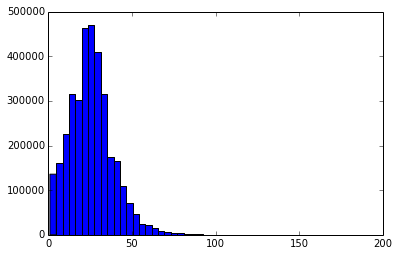

In [218]:
findNoOfFragments("/s/oak/b/nobackup/muggli/goat/whole_genome_mapping/goat_whole_genome.maps")

In [166]:
findNoOfFragments("sim_single_molecule")

25.4556773106
13.2268538833


23.3318181818


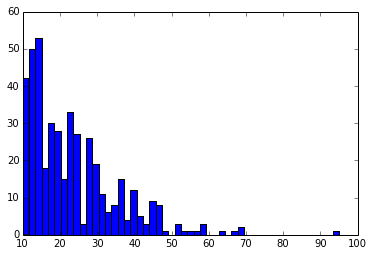

In [219]:
findNoOfFragments("sim_single_molecule_longer")

22.4797843666


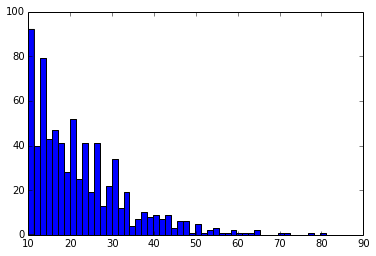

In [233]:
findNoOfFragments("sim_single_molecule_longer_200")

# ------------- With BioNano deletion error rate --------------

In [573]:
# standard deviation with Bionano data
def signmaS(len):
    singma = (0.2*0.2) + len * 0.1 * (-0.1) + len*len*0.04*0.04
    return(singma)

handle = open("/s/fir/a/nobackup/data/ECOLI_Reference_Genome/ecoli.fa", "rU")
for record in Bio.SeqIO.parse(handle, "fasta"):
    ref_seq = record.seq
frag_sizes = [len(seq) for seq in Bio.Restriction.XhoI.catalyse(ref_seq)]

def subseq(seq, limits):
    x,y = limits
    if x < y : return seq[x:y]
    return seq[x:len(seq)] + seq[0:y]

molecules = []
for i in range(400):
    breaks = []
    num_breaks = 10 #random.randint(20,50)
    for j in range(num_breaks):
        breaks.append(random.randint(0,len(ref_seq) - 1))
    breaks.sort()        
    pairs = [(x,y) for x,y in zip(breaks[:-1], breaks[1:])] + [(breaks[-1], breaks[0])]
    molecules += [[subseq(ref_seq, pair), pair] for pair in pairs]

In [574]:
def generateRandomList(listv, count):
    randomList = []
    randomListIndex = []
    index = range(0, len(listv))
    for c in range(0, count):               
        i = random.choice(index)
        randomList.append(listv[i])
        randomListIndex.append(i)
        index.remove(i)
    randomListIndex, randomList = zip(*sorted(zip(randomListIndex,randomList)))
    return(randomListIndex, randomList)

def deleteRandomly(listv, count):
    deleted = generateRandomList(listv, count)
    deleted_index = list(deleted[0])
    deleted_values = list(deleted[1])    
    for d in deleted_values:
        listv.remove(d)
    return(listv, deleted_index, deleted_values)

def sim(mol):
    "Return a simulated set of fragment sizes in bp for a Bio.SeqIO seq"    
    sites = [biosite - 1 for biosite in Bio.Restriction.XhoI.search(mol)]
    e_f_sites = list(sites);
    
    sites, dindex, dsites = deleteRandomly( sites, int(len(mol)/100000))    
            
    allsites = [0] + sites + [len(mol)]
    e_f_allsites = [0] + e_f_sites + [len(mol)]    
    # TODO add random break sites
    sizes = [y - x for x,y in zip(allsites[:-1], allsites[1:])]
    e_f_sizes = [y - x for x,y in zip(e_f_allsites[:-1], e_f_allsites[1:])]
    sizes = [size/1000.0 for size in sizes] # convert to kb
    e_f_sizes = [size/1000.0 for size in e_f_sizes] # convert to kb    
    sizes = [size + random.gauss(0, math.sqrt(signmaS(size))) for size in sizes if size > 0.5]
    sizes = [size for size in sizes if size > 0.5]
    e_f_sizes = [size for size in e_f_sizes if size > 0.5]
    return (sizes, e_f_sizes, dindex)

In [575]:
filename = "sim_single_molecule_100"
m = open(filename+"_newDel","w")
mwe = open(filename+"_efree","w")
efile  = open(filename+"_elocations","w")

start = 0
end = 0
length_of_original = []
length_of_errored = []
accum = 0
for i, mol in enumerate((molecule for molecule in molecules if len(molecule[0]) > 250000)):
    simulated = sim(mol[0])  
    accum += sum(simulated[1])
    lens = [str(round(frag,3)) for frag in simulated[0]]
    if len(lens) < 10: continue
    map_name = "map_" + str(i) + "\n"
    
    lens_e_free = [str(round(frag,3)) for frag in simulated[1]]
    length_of_errored.append(len(lens))
    length_of_original.append(len(lens_e_free))
    #if i == 100: break

    if(start == 0 and end ==0):
        start = mol[1][0]
        end = mol[1][1]
    
#    elif(start <= mol[1][0] and mol[1][0] >= end):
    if((start <= mol[1][0] and mol[1][0] <= end) or (start <= mol[1][1] and mol[1][1] <= end) or (start >= mol[1][0] and mol[1][1] >= end)):
        m.write(map_name)
        m.write("\tXhoI\tXhoI\t" + "\t".join(lens) + "\n")
        m.write("\n")
        
        mwe.write(map_name)
        mwe.write("\tXhoI\tXhoI\t" + "\t".join(lens_e_free) + "\n")
        mwe.write("\n")
                
        efile.write(' '.join([str(s) for s in simulated[2]]))
        efile.write("\n")
"""        
    elif(start <= mol[1][1] and mol[1][0] >= end):
        m.write("map_" + str(i) + "\n")
        m.write("\tXhoI\tXhoI\t" + "\t".join(lens) + "\n")        
        m.write("\n")
        
        mwe.write(map_name)
        mwe.write("\tXhoI\tXhoI\t" + "\t".join(lens_e_free) + "\n")
        mwe.write("\n")
                
        efile.write(' '.join([str(s) for s in simulated[2]]))
        efile.write("\n")
"""
m.close()
mwe.close()
efile.close()

# ------------- With BioNano deletion error rate (V2) --------------

In [208]:
# standard deviation with Bionano data
def signmaS(len):
    singma = (0.2*0.2) + len * 0.1 * (-0.1) + len*len*0.04*0.04
    return(singma)

handle = open("/s/fir/a/nobackup/data/ECOLI_Reference_Genome/ecoli.fa", "rU")
for record in Bio.SeqIO.parse(handle, "fasta"):
    ref_seq = record.seq
frag_sizes = [len(seq) for seq in Bio.Restriction.XhoI.catalyse(ref_seq)]

def subseq(seq, limits):
    x,y = limits
    if x < y : return seq[x:y]
    return seq[x:len(seq)] + seq[0:y]

molecules = []
for i in range(500):
    breaks = []
    num_breaks = 10 #random.randint(20,50)
    for j in range(num_breaks):
        breaks.append(random.randint(0,len(ref_seq) - 1))
    breaks.sort()        
    pairs = [(x,y) for x,y in zip(breaks[:-1], breaks[1:])] + [(breaks[-1], breaks[0])]
    molecules += [[subseq(ref_seq, pair), pair] for pair in pairs]

In [209]:
def generateRandomList(listv, count):
    randomList = []
    randomListIndex = []
    if(count >= len(listv) + 1):
        return(randomListIndex, randomList)
    if(count <= 0):
        return(randomListIndex, randomList)
    if(len(listv) == 0):
        return(randomListIndex, randomList)
    
    index = range(0, len(listv))
    for c in range(0, count):
        i = random.choice(index)
        randomList.append(listv[i])
        randomListIndex.append(i)
        index.remove(i)
    
    randomListIndex, randomList = zip(*sorted(zip(randomListIndex,randomList)))
    return(randomListIndex, randomList)

def deleteRandomly(listv, count):
    deleted = generateRandomList(listv, count)
    deleted_index = list(deleted[0])
    deleted_values = list(deleted[1])    
    for d in deleted_values:
        listv.remove(d)
    return(listv, deleted_index, deleted_values)

def insertVal(A, val):
    idx = A.index(val)
    if(idx == 0):
        A.insert(idx, random.randint(0, A[idx]))
    else:
        A.insert(idx, random.randint((A[idx - 1 ]), A[idx]))
        
def addfalsepositive(listv, count):
    if(count == 0):
        return(listv, count)
    err_cites,sel_val = generateRandomList(listv, count)
    for val in sel_val:
        insertVal(listv, val)
    return(listv, err_cites, count)

def sim(mol):
    "Return a simulated set of fragment sizes in bp for a Bio.SeqIO seq"    
    sites = [biosite - 1 for biosite in Bio.Restriction.XhoI.search(mol)]
    e_f_sites = list(sites);    
    sites, dindex, dsites = deleteRandomly( sites, int(round(len(sites)/6.66)))    
    sites, iindex, ins_err = addfalsepositive(sites, int(round(len(mol)/400000.0)))
    allsites = [0] + sites + [len(mol)]
    e_f_allsites = [0] + e_f_sites + [len(mol)]    
    # TODO add random break sites
    sizes = [y - x for x,y in zip(allsites[:-1], allsites[1:])]
    e_f_sizes = [y - x for x,y in zip(e_f_allsites[:-1], e_f_allsites[1:])]
    sizes = [size/1000.0 for size in sizes] # convert to kb
    e_f_sizes = [size/1000.0 for size in e_f_sizes] # convert to kb
    
    sizes = [size + random.gauss(0, math.sqrt(signmaS(size))) for size in sizes if size > 0.5]
    sizes = [size for size in sizes if size > 0.5]
    e_f_sizes = [size for size in e_f_sizes if size > 0.5]
    return (sizes, e_f_sizes, dindex, ins_err, iindex)

In [211]:
filename = "sim_single_molecule_100"
m = open(filename+"_newDel","w")
mwe = open(filename+"_efree","w")
efile  = open(filename+"_elocations","w")

start = 0
end = 0
length_of_original = []
length_of_errored = []
accum = 0
tot_ins_err = 0
tot_del_err = 0
for i, mol in enumerate((molecule for molecule in molecules if len(molecule[0]) > 250000)):
    simulated = sim(mol[0])      
    lens = [str(round(frag,3)) for frag in simulated[0]]
    if len(lens) < 10: continue
    map_name = "map_" + str(i) + "\n"
    
    lens_e_free = [str(round(frag,3)) for frag in simulated[1]]
    length_of_errored.append(len(lens))
    length_of_original.append(len(lens_e_free))
    #if i == 100: break
    tot_ins_err += simulated[3]
    tot_del_err += len(simulated[2])
    
    if(start == 0 and end ==0):
        start = mol[1][0]
        end = mol[1][1]
    
#    elif(start <= mol[1][0] and mol[1][0] >= end):
#    if((start <= mol[1][0] and mol[1][0] <= end) or (start <= mol[1][1] and mol[1][1] <= end) or (start >= mol[1][0] and mol[1][1] >= end)):
    m.write(map_name)
    m.write("\tXhoI\tXhoI\t" + "\t".join(lens) + "\n")
    m.write("\n")

    mwe.write(map_name)
    mwe.write("\tXhoI\tXhoI\t" + "\t".join(lens_e_free) + "\n")
    mwe.write("\n")

    efile.write(','.join([str(s) for s in simulated[2]]) + ' : ' + ','.join([str(s) for s in simulated[4]]))
    efile.write("\n")
"""        
    elif(start <= mol[1][1] and mol[1][0] >= end):
        m.write("map_" + str(i) + "\n")
        m.write("\tXhoI\tXhoI\t" + "\t".join(lens) + "\n")        
        m.write("\n")
        
        mwe.write(map_name)
        mwe.write("\tXhoI\tXhoI\t" + "\t".join(lens_e_free) + "\n")
        mwe.write("\n")
                
        efile.write(' '.join([str(s) for s in simulated[2]]))
        efile.write("\n")
"""
m.close()
mwe.close()
efile.close()
print("Total insertion errors: " + str(tot_ins_err))
print("Total deletion errors : "+ str(tot_del_err))

Total insertion errors: 5119
Total deletion errors : 11929


# ------------- With BioNano deletion error rate (V3) --------------

In [82]:
# standard deviation with Bionano data
def signmaS(len):
    singma = (0.2*0.2) + len * 0.1 * (-0.1) + len*len*0.04*0.04
    return(singma)

handle = open("/s/fir/a/nobackup/data/ECOLI_Reference_Genome/ecoli.fa", "rU")
for record in Bio.SeqIO.parse(handle, "fasta"):
    ref_seq = record.seq
frag_sizes = [len(seq) for seq in Bio.Restriction.XhoI.catalyse(ref_seq)]

def subseq(seq, limits):
    x,y = limits
    if x < y : return seq[x:y]
    return seq[x:len(seq)] + seq[0:y]

molecules = []
for i in range(500):
    breaks = []
    num_breaks = 10 #random.randint(20,50)
    for j in range(num_breaks):
        breaks.append(random.randint(0,len(ref_seq) - 1))
    breaks.sort()        
    pairs = [(x,y) for x,y in zip(breaks[:-1], breaks[1:])] + [(breaks[-1], breaks[0])]
    molecules += [[subseq(ref_seq, pair), pair] for pair in pairs]

In [83]:
def generateRandomList(listv, count):
    randomList = []
    randomListIndex = []
    if(count >= len(listv)):
        return(randomListIndex, randomList)
    if(count <= 0):
        return(randomListIndex, randomList)
    if(len(listv) == 0):
        return(randomListIndex, randomList)
    
    index = range(0, len(listv) - 1)
    for c in range(0, count):
        i = random.choice(index)
        randomList.append(listv[i])
        randomListIndex.append(i)
        index.remove(i)
    
    randomListIndex, randomList = zip(*sorted(zip(randomListIndex,randomList)))
    return(randomListIndex, randomList)

def deleteRandomly(listv, count):
    deleted = generateRandomList(listv, count)
    deleted_index = list(deleted[0])
    deleted_values = list(deleted[1])
    for i in reversed(deleted_index):        
        listv[i+1] = listv[i+1] + listv[i]
        listv.remove(listv[i])
    return(listv, deleted_index, deleted_values)

def insertVal(A, val):
    idx = A.index(val)        
    r = round(random.uniform(0.0, val), 3)
    A[idx] = r
    A.insert(idx, round((val - r), 3))
        
def addfalsepositive(listv, count):
    if(count == 0):
        return(listv, count)
    err_cites, sel_val = generateRandomList(listv, count)
    for val in reversed(sel_val):
        insertVal(listv, val)
    return(listv, err_cites, count)

def sim(mol):
    "Return a simulated set of fragment sizes in bp for a Bio.SeqIO seq"    
    sites = [biosite - 1 for biosite in Bio.Restriction.XhoI.search(mol)]    
    allsites = [0] + sites + [len(mol)]
    sizes = [y - x for x,y in zip(allsites[:-1], allsites[1:])]
    sizes = [size/1000.0 for size in sizes] # convert to kb
    sizes = [size for size in sizes if size > 1.1]
    if(bool(random.getrandbits(1)) == True):
        sizes = sizes[::-1]
    sizes = sizes[1:-1]
    e_f_sizes = list(sizes);
    sizes, dindex, dsites = deleteRandomly( sizes, int(round(len(sites)/6.66)))    
    sizes, iindex, ins_err = addfalsepositive(sizes, int(round(len(mol)/400000.0)))
    sizes = [size + random.gauss(0, math.sqrt(signmaS(size))) for size in sizes if size > 0.5]
    sizes = [size for size in sizes if size > 0.5]    
    return (sizes, e_f_sizes, dindex, ins_err, iindex)

In [84]:
filename = "sim_single_molecule_100"
m = open(filename+"_newDel","w")
mwe = open(filename+"_efree","w")
efile  = open(filename+"_elocations","w")

start = 0
end = 0
length_of_original = []
length_of_errored = []
accum = 0
tot_ins_err = 0
tot_del_err = 0
for i, mol in enumerate((molecule for molecule in molecules if len(molecule[0]) > 250000)):
    simulated = sim(mol[0])      
    lens = [str(round(frag,3)) for frag in simulated[0]]
    if len(lens) < 10: continue
    map_name = "map_" + str(i) + "\n"
    
    lens_e_free = [str(round(frag,3)) for frag in simulated[1]]
    length_of_errored.append(len(lens))
    length_of_original.append(len(lens_e_free))
    #if i == 100: break
    tot_ins_err += simulated[3]
    tot_del_err += len(simulated[2])
    
    if(start == 0 and end ==0):
        start = mol[1][0]
        end = mol[1][1]
    
#    elif(start <= mol[1][0] and mol[1][0] >= end):
#    if((start <= mol[1][0] and mol[1][0] <= end) or (start <= mol[1][1] and mol[1][1] <= end) or (start >= mol[1][0] and mol[1][1] >= end)):
    m.write(map_name)
    m.write("\tXhoI\tXhoI\t" + "\t".join(lens) + "\n")
    m.write("\n")

    mwe.write(map_name)
    mwe.write("\tXhoI\tXhoI\t" + "\t".join(lens_e_free) + "\n")
    mwe.write("\n")

    efile.write(','.join([str(s) for s in simulated[2]]) + ' : ' + ','.join([str(s) for s in simulated[4]]))
    efile.write("\n")

m.close()
mwe.close()
efile.close()
print("Total insertion errors: " + str(tot_ins_err))
print("Total deletion errors : "+ str(tot_del_err))

Total insertion errors: 4803
Total deletion errors : 11303


In [85]:
!cp /s/oak/b/nobackup/darshanw/ipython-notebooks/sim_single_molecule_100_newDel /s/oak/b/nobackup/darshanw/COmap/test/

In [86]:
!cp /s/oak/b/nobackup/darshanw/ipython-notebooks/sim_single_molecule_100_efree /s/oak/b/nobackup/darshanw/COmap/test/

In [87]:
!cp /s/oak/b/nobackup/darshanw/ipython-notebooks/sim_single_molecule_100_elocations /s/oak/b/nobackup/darshanw/COmap/test/

In [117]:
A = [20, 40 ,55, 78, 90, 11]
index = []
for i in range(0, len(A)):
    if(A[i] <= 50):
        index.append(i)
index        

[0, 1, 5]

In [167]:
for i in range(0, 10000):
    if((1.1 + random.gauss(0, math.sqrt(signmaS(1.1)))) < 0.5):
        print("poop")

poop


In [195]:
A = [40.0, 23, 31, 39.9, 50, 62]
def removeLessthan(A, no):
    removedindex = []
    removedvalues = [] 
    for i in range(0, len(A)):
        if(A[i] < no):
            removedindex.append(i)
            removedvalues.append(A[i])
    for v in removedvalues:
        A.remove(v)
        
    return(A, removedindex)

a,_ = removeLessthan(A, 30)

In [273]:

def deleteRandomly(listv, count):
    D = generateRandomList(listv, count)
    deleted_index = list(D[0])
    deleted_values = list(D[1])
    for i in deleted_index:
        if(i == len(listv)):
            return(listv, [], [])
        else:
            listv
            listv.remove(d)
            
    return(listv, deleted_index, deleted_values)

In [328]:
def insertVal(A, val):
    idx = A.index(val)        
    r = round(random.uniform(0.0, val), 3)
    A[idx] = r
    A.insert(idx, round((val - r), 3))

In [329]:
def addfalsepositive(listv, count):
    if(count == 0):
        return(listv, count)
    err_cites, sel_val = generateRandomList(listv, count)
    for val in reversed(sel_val):
        insertVal(listv, val)
    return(listv, err_cites, count)

# ------------- With BioNano deletion error rate (V4) --------------

In [89]:
# standard deviation with Bionano data
def signmaS(len):
    singma = (0.2*0.2) + len * 0.1 * (-0.1) + len*len*0.04*0.04
    return(singma)

handle = open("/s/fir/a/nobackup/data/ECOLI_Reference_Genome/ecoli.fa", "rU")
for record in Bio.SeqIO.parse(handle, "fasta"):
    ref_seq = record.seq
frag_sizes = [len(seq) for seq in Bio.Restriction.XhoI.catalyse(ref_seq)]

def subseq(seq, limits):
    x,y = limits
    if x < y : return seq[x:y]
    return seq[x:len(seq)] + seq[0:y]

molecules = []
for i in range(700):
    breaks = []
    num_breaks = 40 #random.randint(20,50)
    for j in range(num_breaks):
        breaks.append(random.randint(0,len(ref_seq) - 1))
    breaks.sort()        
    pairs = [(x,y) for x,y in zip(breaks[:-1], breaks[1:])] + [(breaks[-1], breaks[0])]
    molecules += [[subseq(ref_seq, pair), pair] for pair in pairs]

In [90]:
def generateRandomList(listv, count):
    randomList = []
    randomListIndex = []
    if(count >= len(listv)):
        return(randomListIndex, randomList)
    if(count <= 0):
        return(randomListIndex, randomList)
    if(len(listv) == 0):
        return(randomListIndex, randomList)
    
    index = range(0, len(listv) - 1)
    for c in range(0, count):
        i = random.choice(index)
        randomList.append(listv[i])
        randomListIndex.append(i)
        index.remove(i)
    
    randomListIndex, randomList = zip(*sorted(zip(randomListIndex,randomList)))
    return(randomListIndex, randomList)

def deleteRandomly(listv, count):
    deleted = generateRandomList(listv, count)
    deleted_index = list(deleted[0])
    deleted_values = list(deleted[1])
    for i in reversed(deleted_index):        
        listv[i+1] = listv[i+1] + listv[i]
        listv.remove(listv[i])
    return(listv, deleted_index, deleted_values)

def insertVal(A, val):
    idx = A.index(val)        
    r = round(random.uniform(0.0, val), 3)
    A[idx] = r
    A.insert(idx, round((val - r), 3))
        
def addfalsepositive(listv, count):
    if(count == 0):
        return(listv, count)
    err_cites, sel_val = generateRandomList(listv, count)
    for val in reversed(sel_val):
        insertVal(listv, val)
    return(listv, err_cites, count)

def sim(mol):
    "Return a simulated set of fragment sizes in bp for a Bio.SeqIO seq"    
    sites = [biosite - 1 for biosite in Bio.Restriction.XhoI.search(mol)]  
    sites.extend([biosite - 1 for biosite in Bio.Restriction.NheI.search(mol)])
    sites.extend([biosite - 1 for biosite in Bio.Restriction.EagI.search(mol)])
    sites.sort()
    
    allsites = [0] + sites + [len(mol)]
    sizes = [y - x for x,y in zip(allsites[:-1], allsites[1:])]
    sizes = [size/1000.0 for size in sizes] # convert to kb
    sizes = [size for size in sizes if size > 1.1]
    if(bool(random.getrandbits(1)) == True):
        sizes = sizes[::-1]
    sizes = sizes[1:-1]
    e_f_sizes = list(sizes);
    sizes, dindex, dsites = deleteRandomly( sizes, int(round(len(sites)/6.66)))    
    sizes, iindex, ins_err = addfalsepositive(sizes, int(round(len(mol)/200000.0)))
    sizes = [size + random.gauss(0, math.sqrt(signmaS(size))) for size in sizes if size > 0.5]
    sizes = [size for size in sizes if size > 0.5]    
    return (sizes, e_f_sizes, dindex, ins_err, iindex)

In [91]:
filename = "sim_single_molecule_100"
m = open(filename+"_newDel","w")
mwe = open(filename+"_efree","w")
efile  = open(filename+"_elocations","w")

start = 0
end = 0
length_of_original = []
length_of_errored = []
accum = 0
tot_ins_err = 0
tot_del_err = 0
for i, mol in enumerate((molecule for molecule in molecules if len(molecule[0]) > 250000)):
    simulated = sim(mol[0])      
    lens = [str(round(frag,3)) for frag in simulated[0]]
    if len(lens) < 10: continue
    map_name = "map_" + str(i) + "\n"
    
    lens_e_free = [str(round(frag,3)) for frag in simulated[1]]
    length_of_errored.append(len(lens))
    length_of_original.append(len(lens_e_free))
    #if i == 100: break
    tot_ins_err += simulated[3]
    tot_del_err += len(simulated[2])
    
    if(start == 0 and end ==0):
        start = mol[1][0]
        end = mol[1][1]
    
#    elif(start <= mol[1][0] and mol[1][0] >= end):
#    if((start <= mol[1][0] and mol[1][0] <= end) or (start <= mol[1][1] and mol[1][1] <= end) or (start >= mol[1][0] and mol[1][1] >= end)):
    m.write(map_name)
    m.write("\tXhoI\tXhoI\t" + "\t".join(lens) + "\n")
    m.write("\n")

    mwe.write(map_name)
    mwe.write("\tXhoI\tXhoI\t" + "\t".join(lens_e_free) + "\n")
    mwe.write("\n")

    efile.write(','.join([str(s) for s in simulated[2]]) + ' : ' + ','.join([str(s) for s in simulated[4]]))
    efile.write("\n")

m.close()
mwe.close()
efile.close()
print("Total insertion errors: " + str(tot_ins_err))
print("Total deletion errors : "+ str(tot_del_err))

Total insertion errors: 5674
Total deletion errors : 23271


In [92]:
!cp /s/oak/b/nobackup/darshanw/ipython-notebooks/sim_single_molecule_100_newDel /s/oak/b/nobackup/darshanw/COmap/test/

In [93]:
!cp /s/oak/b/nobackup/darshanw/ipython-notebooks/sim_single_molecule_100_efree /s/oak/b/nobackup/darshanw/COmap/test/

In [94]:
!cp /s/oak/b/nobackup/darshanw/ipython-notebooks/sim_single_molecule_100_elocations /s/oak/b/nobackup/darshanw/COmap/test/

# ============Experiments==================

In [20]:
handle = open("/s/fir/a/nobackup/data/ECOLI_Reference_Genome/ecoli.fa", "rU")
for record in Bio.SeqIO.parse(handle, "fasta"):
    ref_seq = record.seq
frag_sizes = [len(seq) for seq in Bio.Restriction.XhoI.catalyse(ref_seq)]
print(frag_sizes)

[47077, 55381, 40525, 2335, 27290, 18043, 7616, 1806, 5554, 23391, 12, 23605, 28270, 24142, 27238, 8511, 6776, 24921, 1462, 5108, 24335, 11058, 27070, 43326, 49950, 51518, 16481, 37904, 4946, 35071, 17610, 58586, 28871, 14231, 71874, 55145, 2763, 37516, 2107, 3698, 2894, 16741, 60041, 36938, 19058, 4897, 32535, 3642, 4556, 17626, 3007, 12754, 28213, 730, 26300, 33522, 9614, 178, 27279, 28887, 13417, 2786, 21812, 24018, 7009, 14835, 72120, 9739, 10360, 64508, 11884, 18627, 28582, 1557, 2506, 1913, 11641, 15440, 8697, 6170, 45312, 4218, 15062, 20234, 12854, 12396, 48964, 34111, 55638, 56159, 48165, 101, 2099, 13095, 111629, 66318, 116010, 32342, 14882, 79243, 504, 4995, 10312, 37236, 32650, 3417, 12928, 87122, 14466, 15855, 110769, 28703, 4878, 24503, 84549, 3166, 25931, 24461, 68447, 70083, 30152, 24183, 11068, 3284, 6952, 28481, 19404, 44525, 38583, 36019, 76733, 3374, 13436, 27244, 13969, 7883, 1620, 58762, 3167, 44549, 24700, 44498, 39605, 8075, 4687, 32319, 18488, 17260, 10482, 4273

In [27]:
from __future__ import division
from Bio import SeqIO
from Bio.Restriction import *
import numpy
multi = (XhoI,NheI,EagI)

handle = open("/s/fir/a/nobackup/data/ECOLI_Reference_Genome/ecoli.fa", "rU")
for record in Bio.SeqIO.parse(handle, "fasta"):
    print(record.id + "\n")       
    print("\tXhoI\tNheI")
    L=[0]
    L.append (len(record)/1000)
    for enz in range(len(multi)):
        coords = multi[enz].search(record.seq)        
        for site in range(len(coords)):            
            L.append(coords[site]/1000)                                    
    L.sort()
        
    for i in range(1, len(L)):
        frags=[str(L[i]-L[i-1])]
        
        print( "\t"+ "\t".join(frags))
    print("\n")        
    print("\n")

ENA|U00096|U00096.2

	XhoI	NheI
	17.75
	7.404
	19.811
	2.113
	3.244
	18.526
	14.427
	3.825
	15.359
	4.25
	19.549
	1.349
	11.122
	4.255
	2.335
	10.299
	11.281
	5.71
	0.26
	1.272
	16.511
	2.447
	5.169
	1.806
	5.554
	19.036
	0.244
	2.756
	1.1
	0.255
	0.012
	10.987
	8.142
	0.57
	3.906
	12.169
	3.862
	12.239
	1.309
	1.62
	2.478
	1.686
	8.984
	8.065
	0.124
	1.068
	0.141
	1.002
	13.349
	11.554
	8.511
	6.776
	5.731
	18.655
	0.535
	1.462
	5.108
	18.31
	3.535
	2.49
	5.763
	5.295
	5.962
	8.346
	10.69
	2.072
	5.612
	16.235
	2.739
	18.74
	4.656
	3.125
	0.218
	14.479
	27.472
	40.897
	1.765
	4.322
	4.044
	0.49
	1.967
	14.514
	3.664
	13.07
	6.524
	9.148
	3.612
	1.886
	3.125
	1.821
	20.182
	1.916
	0.069
	3.254
	0.782
	8.868
	0.327
	11.398
	5.885
	5.826
	8.51
	18.15
	0.471
	11.599
	14.03
	17.494
	2.021
	9.356
	14.231
	14.004
	5.219
	10.978
	5.715
	35.958
	11.655
	3.433
	1.694
	15.842
	11.457
	2.234
	8.83
	2.763
	0.571
	2.127
	0.675
	9.958
	17.017
	2.836
	1.039
	3.293
	2.107
	3.698
	2.894
	9.824
	6.917
	

In [61]:
sites = [biosite - 1 for biosite in Bio.Restriction.XhoI.search(molecules[3][0])] 
sites

[8782,
 73290,
 85174,
 103801,
 132383,
 133940,
 136446,
 138359,
 150000,
 165440,
 174137,
 180307,
 225619,
 229837,
 244899,
 265133,
 277987,
 290383,
 339347,
 373458,
 429096,
 485255,
 533420,
 533521,
 535620,
 548715,
 660344,
 726662]

In [64]:
sites = [biosite - 1 for biosite in Bio.Restriction.XhoI.search(molecules[3][0])] 
sites = []
sites.extend([biosite - 1 for biosite in Bio.Restriction.NheI.search(molecules[3][0])])
sites.sort()
sites

[107161,
 113086,
 129386,
 145286,
 170657,
 197332,
 287386,
 375337,
 445541,
 467511,
 530285,
 538996,
 577342,
 595515,
 655313,
 688739,
 691178,
 713109,
 716661,
 719806,
 743683]

In [26]:
handle = open("/s/fir/a/nobackup/data/ECOLI_Reference_Genome/ecoli.fa", "rU")
for record in Bio.SeqIO.parse(handle, "fasta"):
    ref_seq = record.seq
frag_sizes = []
for seq in Bio.Restriction.XhoI.catalyse(ref_seq):    
    for seq1 in Bio.Restriction.NheI.catalyse(seq):
        for seq2 in Bio.Restriction.EagI.catalyse(seq1):
            frag_sizes.append(len(seq2))
print(frag_sizes)

[17749, 7404, 19811, 2113, 3244, 18526, 14427, 3825, 15359, 4250, 19549, 1349, 11122, 4255, 2335, 10299, 11281, 5710, 260, 1272, 16511, 2447, 5169, 1806, 5554, 19036, 244, 2756, 1100, 255, 12, 10987, 8142, 570, 3906, 12169, 3862, 12239, 1309, 1620, 2478, 1686, 8984, 8065, 124, 1068, 141, 1002, 13349, 11554, 8511, 6776, 5731, 18655, 535, 1462, 5108, 18310, 3535, 2490, 5763, 5295, 5962, 8346, 10690, 2072, 5612, 16235, 2739, 18740, 4656, 3125, 218, 14479, 27472, 40897, 1765, 4322, 4044, 490, 1967, 14514, 3664, 13070, 6524, 9148, 3612, 1886, 3125, 1821, 20182, 1916, 69, 3254, 782, 8868, 327, 11398, 5885, 5826, 8510, 18150, 471, 11599, 14030, 17494, 2021, 9356, 14231, 14004, 5219, 10978, 5715, 35958, 11655, 3433, 1694, 15842, 11457, 2234, 8830, 2763, 571, 2127, 675, 9958, 17017, 2836, 1039, 3293, 2107, 3698, 2894, 9824, 6917, 6982, 14137, 7232, 8882, 22808, 8267, 6946, 4937, 16788, 19058, 4897, 11668, 20867, 512, 3130, 4556, 1255, 16371, 3007, 12754, 10541, 13350, 4322, 730, 22255, 4045, 23

In [30]:
handle = open("/s/fir/a/nobackup/data/ECOLI_Reference_Genome/ecoli.fa", "rU")
for record in Bio.SeqIO.parse(handle, "fasta"):
    ref_seq = record.seq
frag_sizes = []
for seq in Bio.Restriction.XhoI.catalyse(ref_seq):    
    for seq1 in Bio.Restriction.NheI.catalyse(seq):
        for seq2 in Bio.Restriction.EagI.catalyse(seq1):
            frag_sizes.append(len(seq2))
frag_sizes

[17749,
 7404,
 19811,
 2113,
 3244,
 18526,
 14427,
 3825,
 15359,
 4250,
 19549,
 1349,
 11122,
 4255,
 2335,
 10299,
 11281,
 5710,
 260,
 1272,
 16511,
 2447,
 5169,
 1806,
 5554,
 19036,
 244,
 2756,
 1100,
 255,
 12,
 10987,
 8142,
 570,
 3906,
 12169,
 3862,
 12239,
 1309,
 1620,
 2478,
 1686,
 8984,
 8065,
 124,
 1068,
 141,
 1002,
 13349,
 11554,
 8511,
 6776,
 5731,
 18655,
 535,
 1462,
 5108,
 18310,
 3535,
 2490,
 5763,
 5295,
 5962,
 8346,
 10690,
 2072,
 5612,
 16235,
 2739,
 18740,
 4656,
 3125,
 218,
 14479,
 27472,
 40897,
 1765,
 4322,
 4044,
 490,
 1967,
 14514,
 3664,
 13070,
 6524,
 9148,
 3612,
 1886,
 3125,
 1821,
 20182,
 1916,
 69,
 3254,
 782,
 8868,
 327,
 11398,
 5885,
 5826,
 8510,
 18150,
 471,
 11599,
 14030,
 17494,
 2021,
 9356,
 14231,
 14004,
 5219,
 10978,
 5715,
 35958,
 11655,
 3433,
 1694,
 15842,
 11457,
 2234,
 8830,
 2763,
 571,
 2127,
 675,
 9958,
 17017,
 2836,
 1039,
 3293,
 2107,
 3698,
 2894,
 9824,
 6917,
 6982,
 14137,
 7232,
 8882,
 228

In [32]:
1+2

3